In [1]:
!pip install pytorch_model_summary

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/dfw
!ls

/content/drive/My Drive/Colab Notebooks/dfw
build  dfw.egg-info  frankwolfe_cnn.ipynb  plot_cifar.png    setup.py
data   dist	     frankwolfe_dnn.ipynb  README.md
dfw    experiments   LICENSE		   requirements.txt


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from pytorch_model_summary import summary

In [5]:
import torchvision
import torchvision.datasets as datasets

#### Goal: Composite optimizers -> Frank Wolfe / SGD / ADAM 

In [6]:
from dfw import DFW
from dfw.losses import MultiClassHingeLoss

In [7]:
def accuracy(y_pred,y_ground):
    return (torch.sum(torch.argmax(y_pred,axis=1) == y_ground) / y_ground.size(0)).item()

### Part 2: CNN Mnist Frank Wolfe grid-search
On Cifar 10

In [8]:
import torchvision.transforms as transforms

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 32, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(32, 64, 5)
        # self.fc1 = nn.Linear(64 * 5 * 5, 312)
        # self.fc2 = nn.Linear(312, 84)

        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 312),
            nn.ReLU(),
            nn.Linear(312, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.base(x)
        x = self.fc3(x)
        return x

<b> Alternate optimizers on batchs </b>

In [28]:
 def train(model,trainloader,testloader, optimizer1, optimizer2, criterion1, criterion2, dfw=(0,0) ): 
    # dfw = (0,0) -> 1st and 2nd criterion not hingeloss
    torch.manual_seed(10)

    acc_val = []
    loss_train = []
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # switch if true to 1st criterion else 2nd
            if torch.rand(1).item() < 0.5:
                # zero the parameter gradients
                optimizer1.zero_grad() 

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion1(outputs, labels)
                loss.backward()
                if dfw[0]:
                  optimizer1.step(lambda: float(loss))
                else:
                  optimizer1.step()
                
            else:
                # zero the parameter gradients
                optimizer2.zero_grad() 

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion2(outputs, labels)
                loss.backward()
                if dfw[1]:
                  optimizer2.step(lambda: float(loss))
                else:
                  optimizer2.step()

            # print statistics
            running_loss += loss.item()
            rep = 1000
            if i % rep == 999:    # print every 2000 mini-batches
                loss_train.append(running_loss/rep)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / rep))
                running_loss = 0.0
                correct = 0
                total = 0
                # since we're not training, we don't need to calculate the gradients for our outputs
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        # calculate outputs by running images through the network
                        outputs = model(images)
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %d %%' % (
                    100 * correct / total))
                acc_val.append(correct / total)
                

    print('Finished Training')
    return loss_train, acc_val

In [31]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.Adam(cnn.parameters(), lr=0.001)

loss_train, acc_val = train(cnn, trainloader, testloader, 
                            optimizer1, optimizer2, 
                            criterion, criterion
                            )

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------
[1,

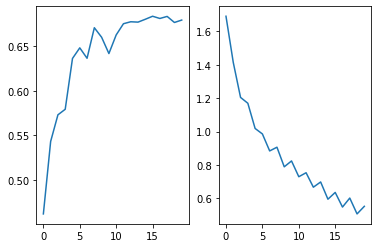

In [32]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

In [34]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion1 = MultiClassHingeLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer1 = DFW(cnn.parameters(), eta=0.001)
optimizer2 = optim.Adam(cnn.parameters(), lr=0.001)

loss_train, acc_val = train(cnn, trainloader, testloader, 
                            optimizer1, optimizer2, 
                            criterion1, criterion2, dfw=(1, 0)
                            )

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------
[1,

### Optim Combinations: Stochastic switch on layers.

<b> Combine SGD ADAM all layers. </b>

In [21]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 312)
        self.fc2 = nn.Linear(312, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [35]:
import random
import itertools

def train2(model,trainloader,testloader, optimizer1_uncall, optimizer2_uncall, criterion1, criterion2, dfw=(0,0) ): 
    # dfw = (0,0) -> 1st and 2nd criterion not hingeloss
    torch.manual_seed(10)

    acc_val = []
    loss_train = []

    for epoch in range(10):  # loop over the dataset multiple times
        layers = [model.conv1.parameters(), model.conv2.parameters(), model.fc1.parameters(), 
              model.fc2.parameters(), model.fc3.parameters()]
        random.shuffle(layers)
        if dfw[0]:
            optimizer1 = optimizer1_uncall(itertools.chain(*layers[:2]), eta=0.01)
        else:
            optimizer1 = optimizer1_uncall(itertools.chain(*layers[:2]), lr=0.001)
        if dfw[1]:
            optimizer2 = optimizer2_uncall(itertools.chain(*layers[2:]), eta=0.01)
        else:
            optimizer2 = optimizer2_uncall(itertools.chain(*layers[2:]), lr=0.001)

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer1.zero_grad() 
            optimizer2.zero_grad() 

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion1(outputs, labels)
            loss.backward()
            if dfw[0]:
                optimizer1.step(lambda: float(loss))
            else:
                optimizer1.step()
            
            outputs = model(inputs)
            loss = criterion2(outputs, labels)
            loss.backward()

            if dfw[1]:
                optimizer2.step(lambda: float(loss))
            else:
                optimizer2.step()

            # print statistics
            running_loss += loss.item()
            rep = 1000
            if i % rep == 999:    # print every 2000 mini-batches
                loss_train.append(running_loss/rep)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / rep))
                running_loss = 0.0
                correct = 0
                total = 0
                # since we're not training, we don't need to calculate the gradients for our outputs
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        # calculate outputs by running images through the network
                        outputs = model(images)
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %d %%' % (
                    100 * correct / total))
                acc_val.append(correct / total)
                

    print('Finished Training')
    return loss_train, acc_val

In [36]:
cnn2 = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))


criterion1 = MultiClassHingeLoss()
criterion2 = nn.CrossEntropyLoss()
optim1_uncall = DFW
optim2_uncall = optim.Adam

loss_train, acc_val = train2(cnn2, trainloader, testloader, 
                            optim1_uncall, optim2_uncall, 
                            criterion1, criterion2, dfw=(1, 0)
                            )

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
          Linear-4           [1, 1600]         499,512         499,512
          Linear-5            [1, 312]          26,292          26,292
          Linear-6             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------
[1,  1000] loss: 2.276
Accuracy of the network on the 10000 test images: 11 %
[1,  2000] loss: 2.298
Accuracy of the network on the 10000 test images: 11 %
[2,  1000] loss: 2.012
Accuracy of the network on the 10000 test images: 20 %
[2,  2000] loss: 2.230
Accuracy of the network on the

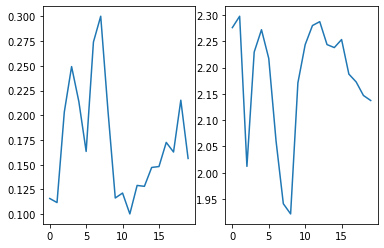

In [37]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

In [38]:
cnn2 = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))


criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optim1_uncall = optim.SGD
optim2_uncall = optim.Adam

loss_train, acc_val = train2(cnn2, trainloader, testloader, 
                            optim1_uncall, optim2_uncall, 
                            criterion1, criterion2, dfw=(0, 0)
                            )

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
          Linear-4           [1, 1600]         499,512         499,512
          Linear-5            [1, 312]          26,292          26,292
          Linear-6             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------
[1,  1000] loss: 1.548
Accuracy of the network on the 10000 test images: 47 %
[1,  2000] loss: 1.171
Accuracy of the network on the 10000 test images: 53 %
[2,  1000] loss: 0.919
Accuracy of the network on the 10000 test images: 56 %
[2,  2000] loss: 0.870
Accuracy of the network on the

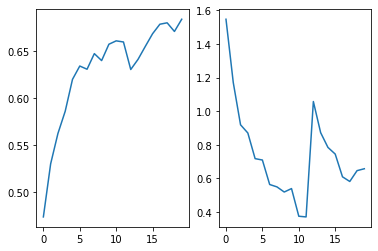

In [39]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)